### Load labels

In [1]:
import pandas as pd

classes_file = "../dataset/class_labels_indices.csv"

df = pd.read_csv(classes_file)
df = df.set_index('index')
df.head(50)

,mid,display_name
index,,
0,/m/09x0r,Speech
1,/m/05zppz,"Male speech, man speaking"
2,/m/02zsn,"Female speech, woman speaking"
3,/m/0ytgt,"Child speech, kid speaking"
4,/m/01h8n0,Conversation
...,...,...
45,/m/07pyy8b,Pant
46,/m/07q0yl5,Snort
47,/m/01b_21,Cough


### Build a function to extract features from audio

In [3]:
import os
import tensorflow as tf
import numpy as np

def extract_all_features(dataset_dir):
    X = []
    y = []
    
    recordset = os.listdir(dataset_dir)
    print(f"Recordset length: {len(recordset)}")
    for record in recordset:
        raw_dataset = tf.data.TFRecordDataset(dataset_dir+record)
        for raw_record in raw_dataset.take(-1):
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())

            labels = example.features.feature['labels'].int64_list.value
                   
            example_seq = tf.train.SequenceExample()
            example_seq.ParseFromString(raw_record.numpy())
                    
            try:
                i=0
                feats_list = example_seq.feature_lists.feature_list['audio_embedding']
                while True:
                    hex_features = feats_list.feature[i].bytes_list.value[0].hex()
                    features_array = [int(hex_features[k:k+2],16) for k in range(0,len(hex_features),2)]
                            # for l in labels_detected:
                                # If there's more than one of the selected labels in the video
                    X.append(features_array)
                    y.append(labels)
                    i += 1
            except IndexError as ie:
                     #FeatureList does not have length, so we read until the end
                continue
                            
    X = np.array(X)
    y = np.array(y, dtype=object)
    
    return X,y

### Extract features from balanced set

In [4]:
X_all, y_all = extract_all_features("../dataset/audioset_v1_embeddings/bal_train/")

Recordset length: 4070


### Count number of values for each label

In [2]:
import matplotlib.pyplot as plt

counters = {}
counters_values = []
for i in y_all:
    for k in i:
        if k in counters_values:
            counters[df.iloc[k]['display_name']] += 1
        else: 
            counters[df.iloc[k]['display_name']] = 0
            counters_values.append(k)


NameError: name 'y_all' is not defined

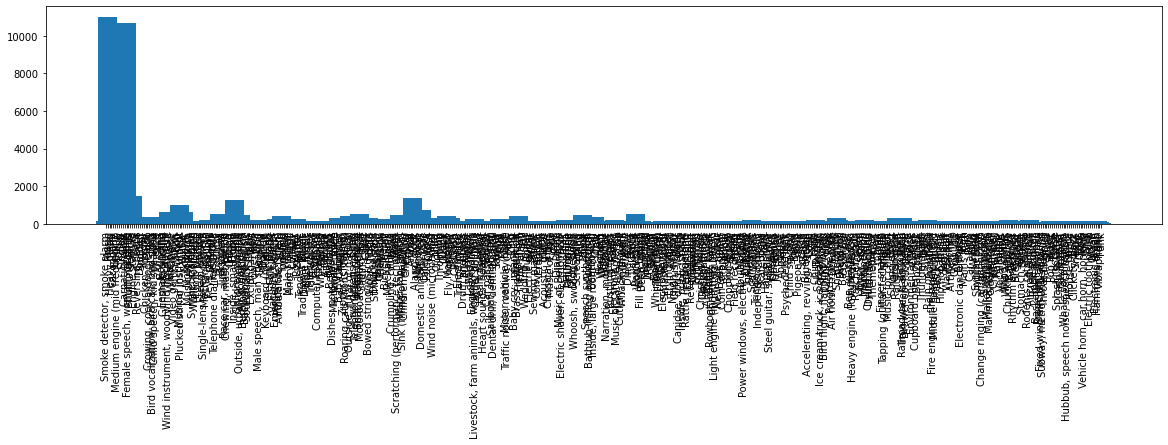

In [24]:
plt.figure(figsize=(20,4))    
plt.bar(counters.keys(), counters.values(), 10)
plt.xticks(rotation = 90)
plt.show()

### Load into a DataFrame

In [57]:
df = pd.DataFrame.from_dict(counters, orient='index', columns=['count'])
df.sort_values(by=['count'], ascending=False).head(10)

,count
Music,62296
Speech,57149
Vehicle,8581
"Inside, small room",7626
Animal,7303
Musical instrument,5319
Singing,5169
"Domestic animals, pets",4108
Guitar,3499
Plucked string instrument,3019


### Select classes
Now, let's see tha data available for the classes we're going to classify

In [60]:
selected_classes = ["Vehicle horn, car horn, honking", "Children playing", "Dog", "Jackhammer", "Siren", 
                    "Traffic noise, roadway noise", "Subway, metro, underground", "Walk, footsteps", "Chatter", "Bird"]

df_sel = df[df.index.isin(selected_classes)]
df_sel.sort_values(by=['count'], ascending=False).head(10)

,count
Dog,2724
Siren,2069
Bird,1716
"Walk, footsteps",599
Chatter,599
Children playing,599
Jackhammer,599
"Subway, metro, underground",599
"Traffic noise, roadway noise",599
"Vehicle horn, car horn, honking",584
